# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Solutions to Homework 10
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 13th, 2018 at 10:59am

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem #1: Iris Eyes Are Smiling

This Homework problem is a continuation of Problem #4 from Homework 8.  We'll be using the same iris dataset. The iris data can be obtained [here](./iris.csv).

Now that we have from Homework 8 Problem #4 a train-test split as well as point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

** *Note this next section is just guidance and doesn't contain any work for you to do* **

*There are two ways to make these predictions, given an estimate of $p(y=1\ \vert\ x)$:* 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

*There are multiple ways in which you can do these probability estimates at a sample $x$:*

(A) You can just use a point estimate like the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

** *Note this next section contains the tasks we expect you to complete* **


1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?
2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 
4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.
5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?


**Solutions**


Let's start by reconstructing our model from Homework #8

In [ ]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

from sklearn.model_selection import train_test_split
import pymc3 as pm

import theano.tensor as t
from theano import shared


**Prepping the Model**

In [2]:
#Read data
df = pd.read_csv('iris.csv', skipinitialspace=True)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
#For converting classification 'Iris-virginica' to 1 and the rest to 0
d = {'Iris-setosa': 0, 'Iris-versicolor': 0, 'Iris-virginica':1}
#Feature dimensions, with bias
D = df.shape[1]
#Number of data points
N = df.shape[0]
#Number of samples
n_samples = 5000

#Train, test split
x_train, x_test, y_train, y_test = train_test_split(np.append(np.ones((df.shape[0], 1)),df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values, axis=1), 
                                                    df['class'].replace(d).values, 
                                                    test_size=0.4)

**Setting Up the Model in Pymc3**

In [6]:
#Input
x_shared = shared(x_train)
#Target
y_shared = shared(y_train)

#Instantiate pymc3 model
logistic_model = pm.Model()

#Set up model
with logistic_model:
    #Prior
    betas = pm.Normal('betas', 0, tau=1/100 , shape=(D, ))
    
    #p(y_j=1 | beta, x_j)
    p = pm.math.invlogit(t.dot(x_shared, betas))
    
    #Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_shared)
    

**Finding the Estimates**

In [8]:
beta_map = pm.find_MAP(model=logistic_model)

logp = -20.858, ||grad|| = 0.19178: 100%|██████████| 30/30 [00:00<00:00, 251.20it/s]  


Our MAP estimate is:

$$\beta_{MAP} =[-10.47553147,  -3.388661  ,  -2.93667342,   5.10897384, 8.81881967]$$

Our mean estimate (calculated below) is:

$$\beta_{MAP} =[-12.93613158  -4.81385222  -3.67415064   7.11943131  10.97103734]$$

**Sampling from the Model**

In [ ]:
#Sampling from model
with logistic_model:
    step = pm.NUTS(scaling = beta_map)
    trace = pm.sample(n_samples, step=step, start=beta_map, random_seed=123)

Now that we have samples of $\beta$, let's compute the posterior mode (MAP) and posterior mean.

**Point Estimates**

In [15]:
#Sigmoid function
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

#Dot product of x and beta
beta_coef = lambda x, beta: x.dot(beta)

#Posterior mean of beta
beta_mean = trace['betas'].mean(axis=0)

print("Our estimate for posterior beta mean: {}".format(beta_mean))

#p(y | beta, x) using posterior mean
p_y_mean = sigmoid(beta_coef(x_train, beta_mean))
#p(y | beta, x) using posterior mode
p_y_MAP = sigmoid(beta_coef(x_train, beta_map['betas']))
#p(y | beta, x) using all posterior samples, that is, we have 5000 p's for
#each training x
p_y_post = sigmoid(beta_coef(x_train, trace['betas'].T))

#Find the training x with p(y | beta_MAP, x) closest to 0.5
indx = np.argmin(np.abs(p_y_MAP - 0.5))


## Find some training x with maps further from 0.5
indices = np.argsort(np.abs(p_y_MAP - 0.5))
indx2 = indices[5]
indx3 = indices[29]


Our estimate for posterior beta mean: [-11.28434972  -6.49173276  -6.89048657  10.55601358  11.762783  ]


Now let's take a look at how to produce a binary classification from a estimate of $p(y_j=1 | x_j)$. 

**I. Training Data**

In [16]:
#Sample from the posterior predictive
posterior_pred = pm.sample_ppc(trace, model=logistic_model)

100%|██████████| 5000/5000 [00:01<00:00, 2763.74it/s]


In [17]:
#P_pp: the fraction of posterior predictives that are 1
p_y_pp = posterior_pred['y_obs'].mean(axis=0)

#Count the number of p's from the posterior samples that are over 0.5
p_y_post_thresh = p_y_post[:, :]
p_y_post_thresh[p_y_post_thresh > 0.5] = 1
p_y_post_thresh[p_y_post_thresh <= 0.5] = 0

#P_cdf
p_y_cdf = p_y_post_thresh.mean(axis=1)

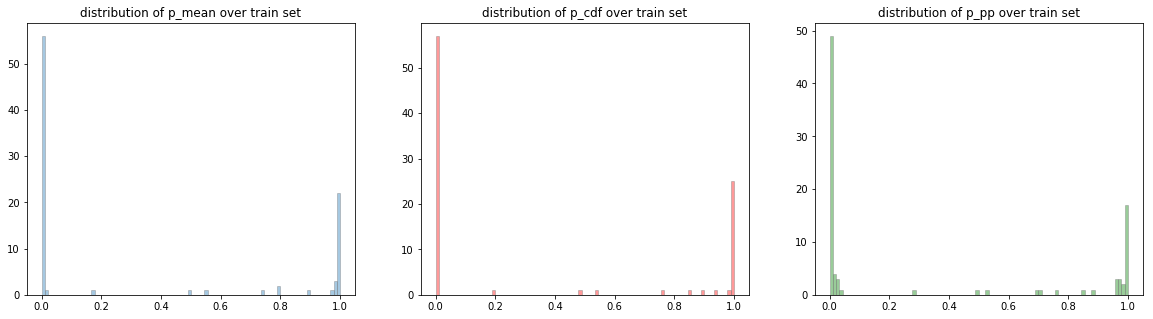

In [18]:
#Distribution of p(y | x, beta) over the training set
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(p_y_mean, bins=90, edgecolor='gray', linewidth='1', alpha=0.4)
ax[0].set_title('distribution of p_mean over train set')

ax[1].hist(p_y_cdf, bins=90, color='red', edgecolor='gray', linewidth='1', alpha=0.4)
ax[1].set_title('distribution of p_cdf over train set')

ax[2].hist(p_y_pp, bins=90, color='green', edgecolor='gray', linewidth='1', alpha=0.4)
ax[2].set_title('distribution of p_pp over train set')
plt.show()

**Analysis:** In the above, we see that the distribution of $p_{PP}$ is the widest of the three. That is, for many more data points, the fraction of posterior predictive classifications of 1 is close to 0.5, whereas there are far fewer data points with $p_{cdf}$ and $p_{mean}$ close to 0.5. In other words, $p_{PP}$ expresses "uncertainty" regarding its classification for many more data points. 

In [19]:
#Posterior predictive misclassification rates over training set
post_pred_misclass = np.abs(y_train - posterior_pred['y_obs']).mean(axis=0)
#Posterior misclassification rates over training set
post_misclass = np.abs(y_train - p_y_post_thresh.T).mean(axis=0)

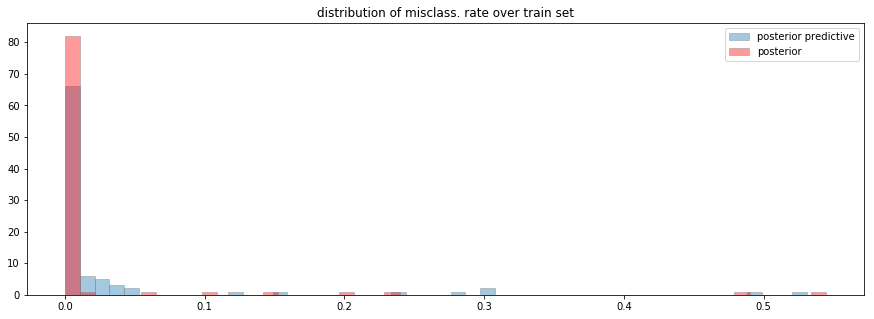

In [20]:
#Distribution of misclassification rates over the training set
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

#Posterior predictve misclassification
ax.hist(post_pred_misclass, bins=50, edgecolor='gray', linewidth='1', alpha=0.4, label='posterior predictive')
#Posterior misclassification
ax.hist(post_misclass, bins=50, color='red', edgecolor='gray', linewidth='1', alpha=0.4, label='posterior')

ax.set_title('distribution of misclass. rate over train set')
ax.legend(loc='best')
plt.show()

**Analysis:** We see from the above that the distribution of the posterior predictive misclassification rates is wider than that of the posterior. Note that this is not to say that using the posterior predictive to classify will lead to a higher error rate in the end! Afterall, in generating the above plot, we have not really produced a single classification for each training data point (i.e. we haven't really produced a final classification of the training set). Rather, the above plot shows the different levels of certainty or conservativeness between the two distributions. In particular, the posterior classifications  are more confident in the sense that we treat a probability of $p(y=1 | \beta, x) = 0.51$ the same as $p(y=1 | \beta, x) = 0.99$ - they both produce a classification of 1. On the otherhand, when we simulate sampling from the posterior predictive, a probability $p(y=1 | \beta, x) = 0.51$ would, conservatively, only yield a classification of 1 half of the time. The wider misclassification rate of the posterior predictive distribution reflects the aforementioned  conservativeness.

**II. Testing Data**

We perform the same analysis on the testing set.

In [21]:
p_y_mean_test = sigmoid(beta_coef(x_test, beta_mean))

p_y_post_test = sigmoid(beta_coef(x_test, trace['betas'].T))

post_pred_test = np.random.binomial(1, p_y_post_test)

p_y_pp = post_pred_test.mean(axis=1)

p_y_post_thresh = p_y_post_test[:, :]
p_y_post_thresh[p_y_post_thresh > 0.5] = 1
p_y_post_thresh[p_y_post_thresh <= 0.5] = 0

p_y_cdf = p_y_post_thresh.mean(axis=1)

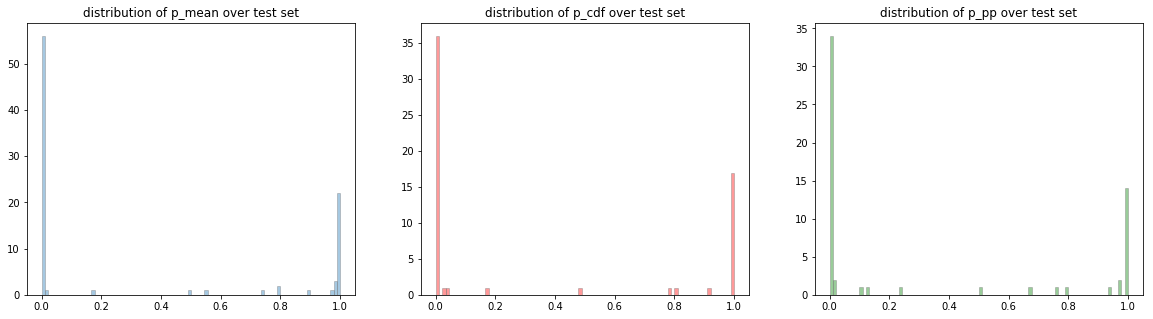

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(p_y_mean, bins=90, edgecolor='gray', linewidth='1', alpha=0.4)
ax[0].set_title('distribution of p_mean over test set')

ax[1].hist(p_y_cdf, bins=90, color='red', edgecolor='gray', linewidth='1', alpha=0.4)
ax[1].set_title('distribution of p_cdf over test set')

ax[2].hist(p_y_pp, bins=90, color='green', edgecolor='gray', linewidth='1', alpha=0.4)
ax[2].set_title('distribution of p_pp over test set')
plt.show()

**Analysis:** Again, in the above, we see that the distribution of $p_{PP}$ is the widest of the three. That is, $p_{PP}$ expresses "uncertainty" regarding its classification for many more data points. 

In [23]:
post_pred_misclass_test= np.abs(y_test - post_pred_test.T).mean(axis=0)
post_misclass_test = np.abs(y_test - p_y_post_thresh.T).mean(axis=0)

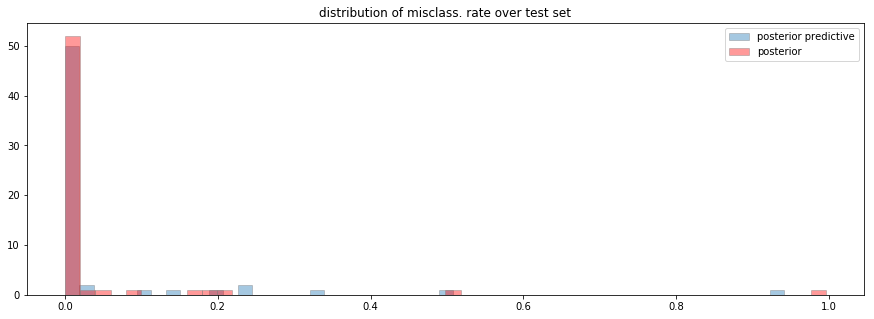

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.hist(post_pred_misclass_test, bins=50, edgecolor='gray', linewidth='1', alpha=0.4, label='posterior predictive')
ax.hist(post_misclass_test, bins=50, color='red', edgecolor='gray', linewidth='1', alpha=0.4, label='posterior')
ax.set_title('distribution of misclass. rate over test set')
ax.legend(loc='best')
plt.show()

**Analysis:** Agian, we see from the above that the distribution of the posterior predictive misclassification rates is wider than that of the posterior. Again, we note that this is not to say that using the posterior predictive to classify will lead to a higher error rate in the end! 

**What is the point of the Iris Dataset problem:** We've explored several ways to estimate $p(y | x)$ - using posterior point estimates and computing $p(y | x)$ as $p(y | \beta, x)$, using the posterior predictive to compute $p(y | x)$ directly - we have also explored several ways to produce a binary classification from a probability $p(y | x)$ or $p(y | \beta, x)$. 

What we have discovered is that some methods produce more "conservative" classifcations than others. But what we have not explored is which method gives us better results in the absolute sense, minimal classification error. In general, it is not the case that one can say using the posterior mean yields less error than MAP, or using posterior point estimates yields more error than posterior predictive. The point of the assignment is to be aware of the existence of multiple choices one can make at every juncture, thus illustrating the need for principled exploration of one's choices (or the careful justification of one's choices).

## Problem 2: From the Ritz to the Rubble

In this problem, much like in Homework 9, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in "Statistical Rethinking", the excerpt of which is included in the data directory for this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

First we want to aggregate the dataset by seven different categories. The categories we wish to consider are: 
- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school
Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) $50k (see the dataset in Example 10.1.3). 

Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

Replicate the analysis in 10.1.3 using your models; specifically, compute= wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. 

Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

**Solution**

**Prepping the Data/Model**

In [2]:
df = pd.read_csv('census_data.csv')
df.head()

,Unnamed: 0,age,sector,edu,marital,race,sex,earning
0,0,39,State-gov,Bachelors,Never-married,White,Male,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K
2,2,38,Private,HS-grad,Divorced,White,Male,<=50K
3,3,53,Private,11th,Married-civ-spouse,Black,Male,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K


Just reading in the data we see that we have tabular data on a number of individuals and that for each individual we keep track of age, employment sector, education, marital status, race, gender, and binary income earning level (income over 50k vs. income under 50k).  We're only going to use education, gender, and earning level in our analyis, and we're going to aggregate the dataset into the 7 categories we've been given in the problem.  Let's organize our data.

In [56]:
cat_1 = ['11th', '7th-8th', '9th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']
cat_2 = ['HS-grad']
cat_3 = ['Some-college', 'Assoc-acdm']
cat_4 = ['Assoc-voc', 'Prof-school']
cat_5 = ['Bachelors']
cat_6 = ['Masters']
cat_7 = ['Doctorate']

labels = ["Some HS", "HS Grad", "Some College", "Prof School", "Bachelors", "Masters", "Doctorate"]

categories = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7]
dataset = []
i = 1
for cat in categories:
    filtered = df[df['edu'].isin(cat)]
    dataset.append((i, 0, len(filtered[filtered['sex'] == 'Female']), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '>50K')])))
    dataset.append((i, 1, len(filtered[filtered['sex'] == 'Male']), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '>50K')])))
    i += 1
dataset = np.array(dataset)
dataset = pd.DataFrame(dataset, columns=['category', 'sex', 'total', '<=50', '>50'])
dataset

,category,sex,total,<=50,>50
0,1,0,1321,1298,23
1,1,1,2932,2711,221
2,2,0,3390,3164,226
3,2,1,7111,5662,1449
4,3,0,3227,2974,253
5,3,1,5131,3732,1399
6,4,0,592,483,109
7,4,1,1366,691,675
8,5,0,1619,1280,339
9,5,1,3736,1854,1882


**Setting up the Basic Income Classification Models in PyMC3**

We want to start as directed by creating models "for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not."

In [4]:
# observed data
n = dataset['total']
x = dataset['sex']
y_obs = dataset['>50']

sample_size = 10000
tune_param = 2000
burnin = 500

In [ ]:
## Income classification model gender no education

with pm.Model() as simple_gender_model:
    
    # define priors
    alpha = pm.Normal('alpha', 0, 10)
    beta_m = pm.Normal('beta_m', 0, 10)
    
    # define likelihood
    p = pm.math.invlogit(alpha + beta_m * x)
    y = pm.Binomial('y_obs', n=n, p=p, observed=y_obs)
       

In [ ]:
with simple_gender_model:
    simple_gender_trace = pm.sample(sample_size, tune=tune_param)

In [62]:
with simple_gender_model:
    simple_gender_ppc = pm.sample_ppc(simple_gender_trace)

100%|██████████| 10000/10000 [00:03<00:00, 3299.23it/s]


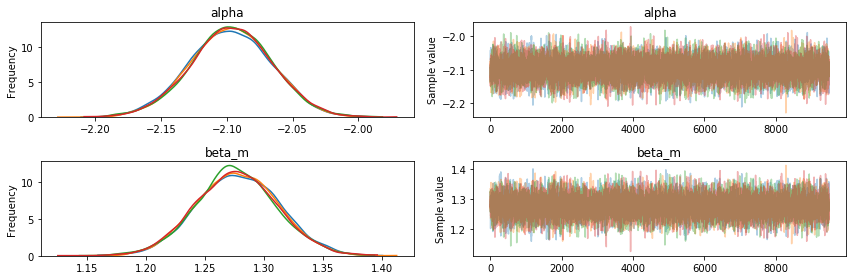

In [6]:
pm.traceplot(simple_gender_trace[burnin:]);

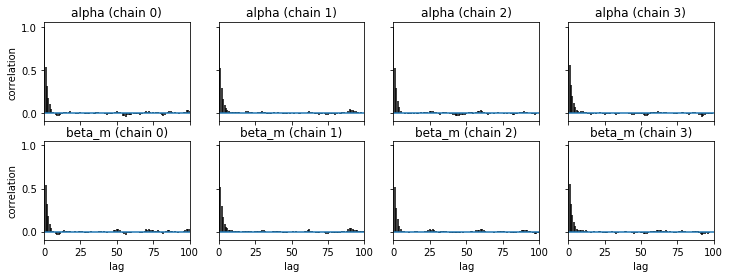

In [7]:
pm.autocorrplot(simple_gender_trace[burnin:]);

In [71]:
# Income classification model no gender no education

with pm.Model() as simple_intercept_only_model:
    #
    alpha = pm.Normal('alpha', 0, 10)
    p = pm.math.invlogit(alpha)
    y = pm.Binomial('y_obs', p=p, n=n, observed=y_obs)


In [ ]:
with simple_intercept_only_model:
    
    simple_intercept_only_trace = pm.sample(sample_size, tune=tune_param)

In [73]:
with simple_intercept_only_model:
    
    simple_intercept_only_ppc = pm.sample_ppc(simple_intercept_only_trace)

100%|██████████| 10000/10000 [00:02<00:00, 4284.21it/s]


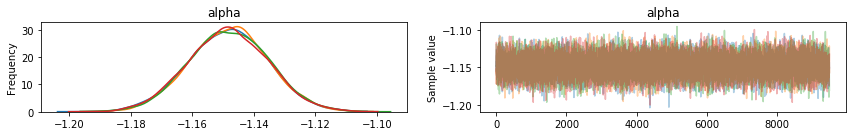

In [9]:
pm.traceplot(simple_intercept_only_trace[burnin:]);

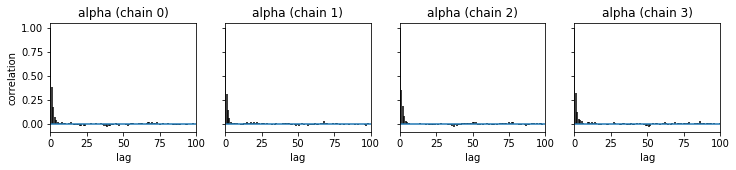

In [10]:
pm.autocorrplot(simple_intercept_only_trace[burnin:]);

Our models are created -- some basic sampler diagnostic checks seem to be ok for both models.  Let's move on to some basic analysis.

**Analysis on the Income Classification Models**


In [11]:
def make_compare(names, traces, models, ic='WAIC'):
    comparedf=pm.compare(traces,models, method='pseudo-BMA')
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf

In [12]:
names=['simple_intercept_only', 'simple_gender']
dfc=make_compare(names, [simple_intercept_only_trace[burnin:], simple_gender_trace[burnin:]],[simple_intercept_only_model, simple_gender_model])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
simple_gender,4621.15,478.58,0,1,1171.63,0,1
simple_intercept_only,6173.41,403.73,1552.26,0,1582.14,1371.24,1


**Analysis:**  We see (via pWAIC) a very large number of estimated model parameters -- more than the one or two we might expect from casual model inspection.  Nonetheless, we see that the additional gender parameters improves the WAIC suggesting that gender has predictive power in income classification.

In [13]:
beta_m_mean = pm.summary(simple_gender_trace[burnin:])['mean']['beta_m']

print("Mean beta_m", beta_m_mean)

Mean beta_m 1.277136500834675


In [14]:
print('Average male advantage', np.exp(beta_m_mean))

Average male advantage 3.586355482205529


In [15]:
logistic = lambda x: 1. / (1 + np.exp(-x))

gender_trace=simple_gender_trace[burnin:]
gender_alpha = gender_trace['alpha']
gender_beta = gender_trace['beta_m']

males = logistic(gender_alpha + gender_beta)
females = logistic(gender_alpha)
diff = males - females
print('Male advantage percentiles', np.percentile(diff, 2.5), np.percentile(diff, 50), np.percentile(diff, 97.5))

Male advantage percentiles 0.18785081722093938 0.19633034853913522 0.20487484675744763


**Analysis:**  Completing an analysis similar to that in Mcelreath, we find that the mean beta_m is 1.27 suggesting a relative difference in odds of being classified at a higher income level of exp(1.27)$\approx$ 3.58.  So an individual male should have a %358 better odds of being earning over \$50k compared to an individual female.  Looking at the quantile differences on an absolute scale for earning over 50k, we see that the 2.5% quantile is 18.8%, the 50% quantile is 19.6% and the 97.5% quantile is 20.5%.  So our median estimate of male advantage is 19.6%

In [143]:
def plot_post_validation_check(ax, above_50k, total, ppc_obs, labels, title=""):
    
    color_map = plt.cm.get_cmap("viridis")
    upper_quantile = np.percentile(ppc_obs, 89, axis=0)
    lower_quantile = np.percentile(ppc_obs, 11, axis=0)

    for i in range(0, 7):
        ax.plot([2*i], (above_50k/ total)[2*i], color= 'darkred', alpha=0.4, marker='H', linestyle='None')
        ax.plot([2*i+1], (above_50k/ total)[2*i+1], color= 'darkblue', alpha=0.4, marker='H', linestyle='None')

        ax.plot([2*i, 2*i+1], (above_50k/ total)[2*i:2*i+2], color = color_map(2/7), linestyle='-')
        
        ax.text(2*i+ 0.6, np.mean((above_50k/total)[2*i:2*i+2]), labels[i],  color = color_map(2/7), ha='left', va='top')
        
        # plot ppc means
        ax.plot([2*i], (ppc_obs.mean(axis=0)/ total)[2*i], color= 'darkred', alpha=0.4, marker='*', linestyle='None')
        ax.plot([2*i+1], (ppc_obs.mean(axis=0)/ total)[2*i+1], color= 'darkblue', alpha=0.4, marker='*', linestyle='None')

        
        # plot percentiles
        ax.plot([2*i], (upper_quantile/total)[2*i], color= 'darkred', alpha=0.4, marker='^', linestyle='None')
        ax.plot([2*i], (lower_quantile/total)[2*i], color= 'darkred', alpha=0.4, marker='v', linestyle='None')

        ax.plot([2*i+1], (upper_quantile/total)[2*i+1], color= 'darkblue',alpha=0.4, marker='^', linestyle='None')
        ax.plot([2*i+1], (lower_quantile/total)[2*i+1], color= 'darkblue',alpha=0.4, marker='v', linestyle='None')
        
        
        

    ax.set_xlim((-0.5, 13.5))
    ax.set_ylim((0, 1))
    ax.set_title("Posterior Validation Check - " + title)
    ax.set_ylabel("Proportion > \$50k")

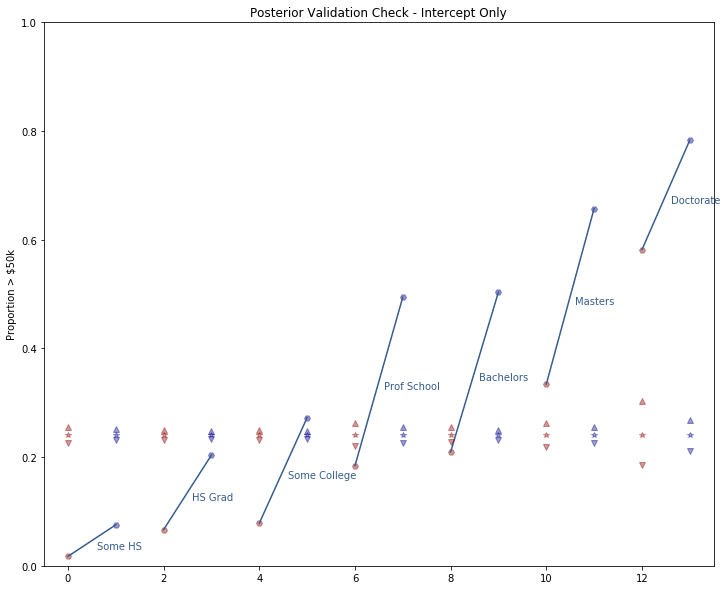

In [144]:
fig, ax = plt.subplots(figsize=(12, 10))

plot_post_validation_check(ax, y_obs, n, simple_intercept_only_ppc['y_obs'], labels, "Intercept Only")

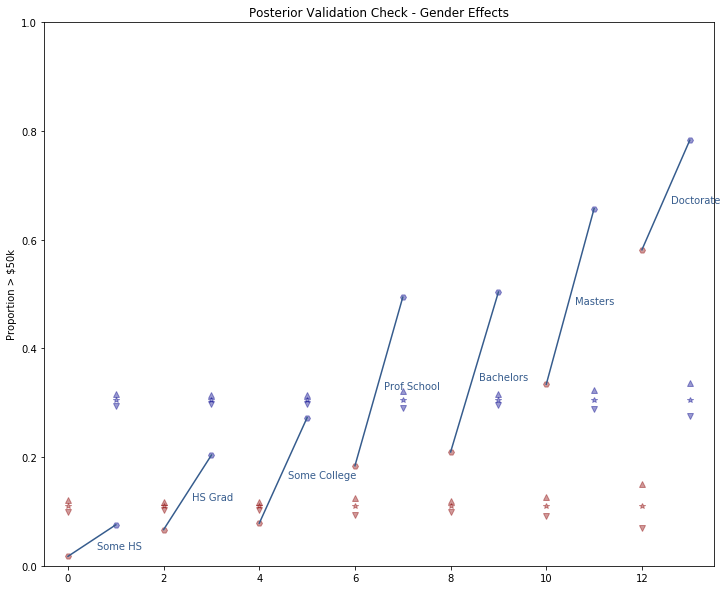

In [145]:
fig, ax = plt.subplots(figsize=(12, 10))

plot_post_validation_check(ax, y_obs, n, simple_gender_ppc['y_obs'], labels, "Gender Effects")

**Analysis:**  Based on the posterior validation check visualization in Example 10.1.3, we have here solid circles to denote the observed proportions of people with a given educational background with incomes above 50k.  The line segments join female and male observations within a specific educational category.  We've used a light red hue to represent female and blue to represent male datapoints and model predictions.  We represent model predictions of proportions of earners within a gender/education category with yearly income over 50K by stars.  We show the 89% intervals of simulated samples with the upper/lower arrows.

The data itself shows two trends:  males earning more than females within any given category and educational category having an impact on incompe potential with generally higher levels of education representing higher proportions earning >50K.  The simple intercept only model doesn't capture either of these trends (as expected), but the binomial regression with gender effects model captures the gender inequality trend.  Both models miss the educational category trend and also give imperfect predictions for proportions of earners within an educational category with incomes > 50K.  We need a richer model.

**Adding Educational Categories to our Basic Income Classification Models**

We want to continue as directed by creating models "for the classification of an individual's yearly income taking into account education."

In [149]:
# Income classification model education and gender
with pm.Model() as education_gender_model:
    
    # priors -- one per education category
    alphas = pm.Normal('alphas', 0, 10, shape=7)
    beta_m = pm.Normal('beta_m', 0, 10)
    
    # define likelihood    
    # create an invLogit on the category in each row of our data i.e. [0, 0, 1, 1, 2, 2 ... 6, 6]
    # add in gender effects
    p = pm.math.invlogit(alphas[np.arange(14)//2] + beta_m * x)
    
    y = pm.Binomial('y_obs', p=p, n=n, observed=y_obs)

In [ ]:
with education_gender_model:
    education_gender_trace = pm.sample(sample_size, tune=tune_param)

In [164]:
with education_gender_model:
    education_gender_ppc = pm.sample_ppc(education_gender_trace)

100%|██████████| 10000/10000 [00:03<00:00, 2827.25it/s]


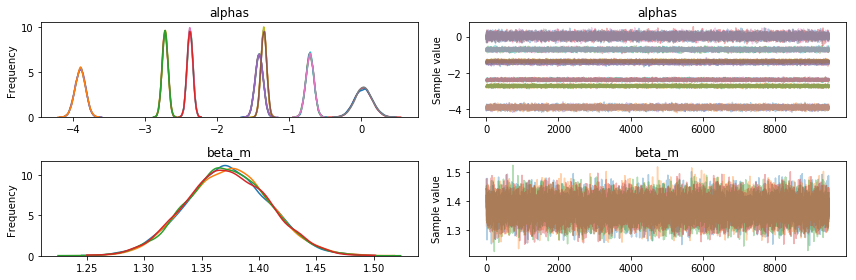

In [153]:
pm.traceplot(education_gender_trace[burnin:]);

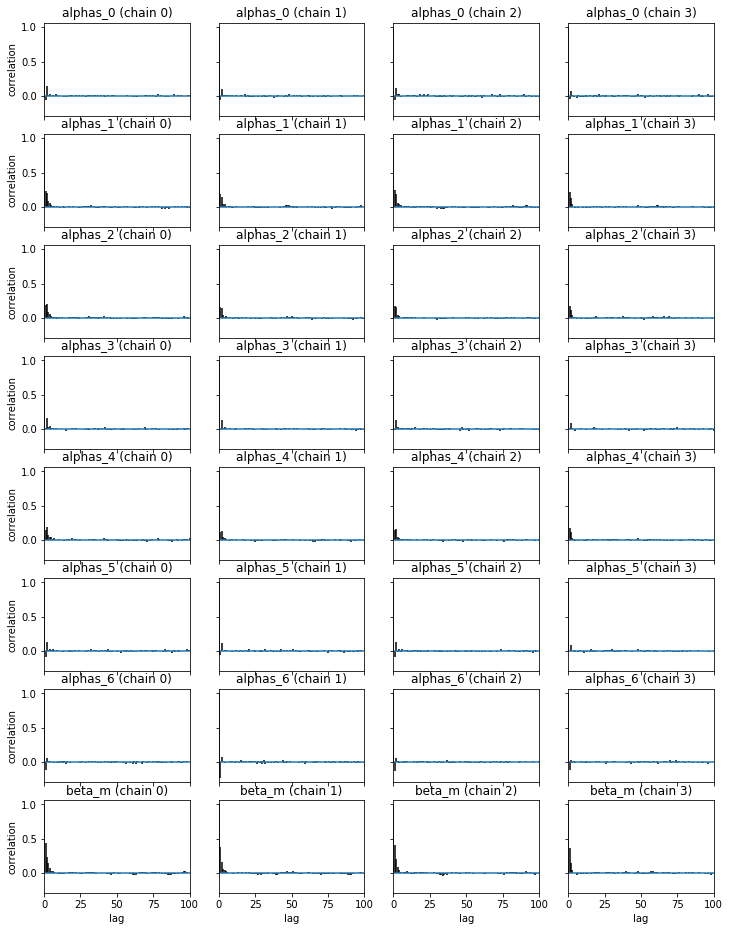

In [154]:
pm.autocorrplot(education_gender_trace[burnin:]);

In [155]:
# Income classification model education but no gender

with pm.Model() as education_only_model:
    
    # priors -- one per education category
    alphas = pm.Normal('alphas', 0, 10, shape=7)
    
    # create an invLogit on the category in each row of our data i.e. [0, 0, 1, 1, 2, 2 ... 6, 6]
    p = pm.math.invlogit(alphas[np.arange(14)//2])
    
    y = pm.Binomial('y_obs', p=p, n=n, observed=y_obs)
    




In [ ]:
with education_only_model:
    
    education_only_trace = pm.sample(sample_size, tune=tune_param)

In [163]:
with education_only_model:
    
    education_only_ppc = pm.sample_ppc(education_only_trace)

100%|██████████| 10000/10000 [00:02<00:00, 3846.81it/s]


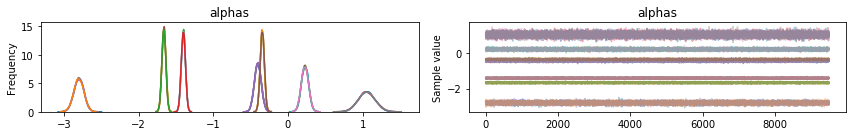

In [159]:
pm.traceplot(education_only_trace[burnin:]);

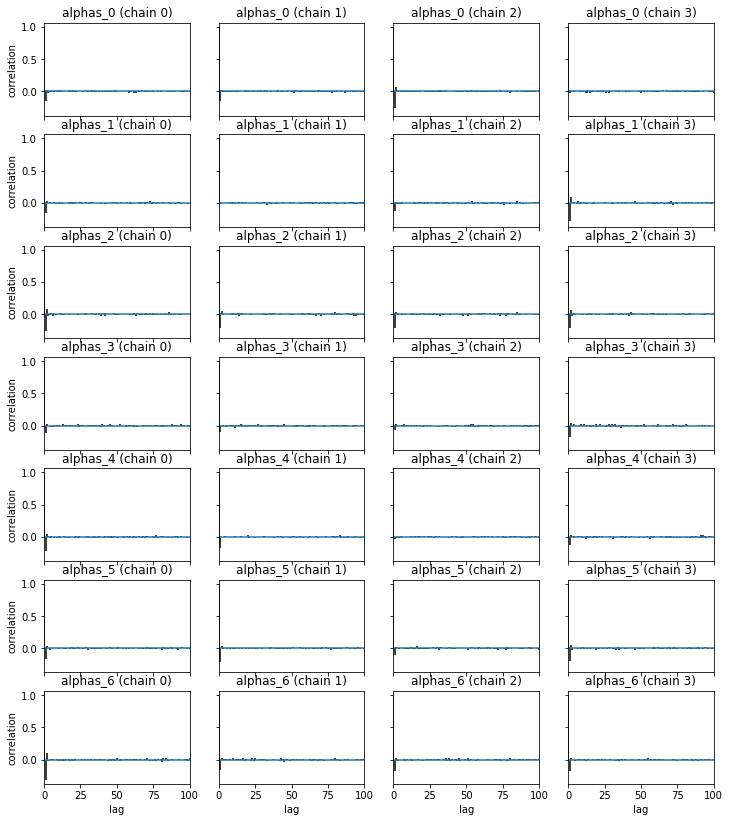

In [160]:
pm.autocorrplot(education_only_trace[burnin:]);

In [167]:
names=['simple_intercept_only', 'simple_gender', 'education_only', 'education_gender']
traces = [simple_intercept_only_trace[burnin:], simple_gender_trace[burnin:], education_only_trace[burnin:], education_gender_trace[burnin:]]
models = [simple_intercept_only_model, simple_gender_model, education_only_model, education_gender_model]
dfc=make_compare(names, traces, models)
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
education_gender,123.53,6.27,0,1,5.69,0,1
education_only,2839.07,705.13,2715.54,0,585.95,582.93,1
simple_gender,4621.15,478.58,4497.62,0,1171.63,1170.9,1
simple_intercept_only,6163.84,399.16,6040.31,0,1575.26,1574.24,1


**Analysis:**  First of all we see that the education models provide a large improvement over the models without education in terms of predictive power. The richest model (incorporating education and gender) has the best WAIC performance as might be expected.  It also has a reasonable prediction via pWAIC for effective number of parameters suggesting that the model is well specified.

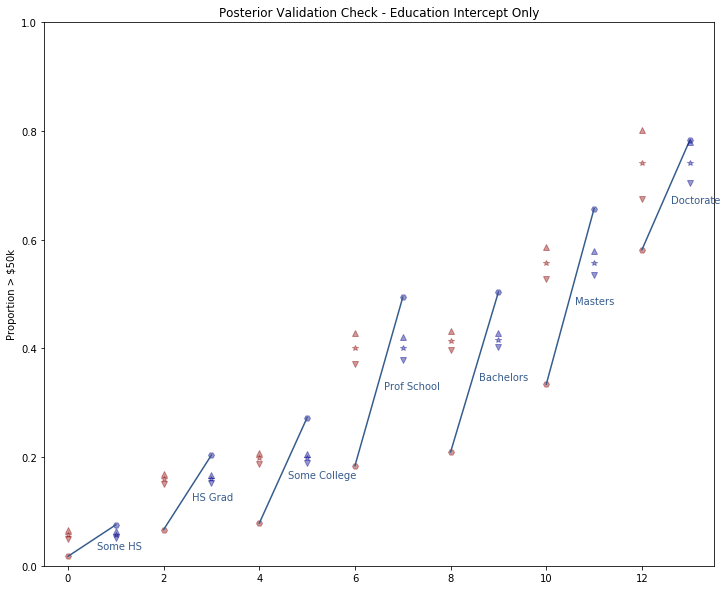

In [165]:
fig, ax = plt.subplots(figsize=(12, 10))

plot_post_validation_check(ax, y_obs, n, education_only_ppc['y_obs'], labels, "Education Intercept Only")

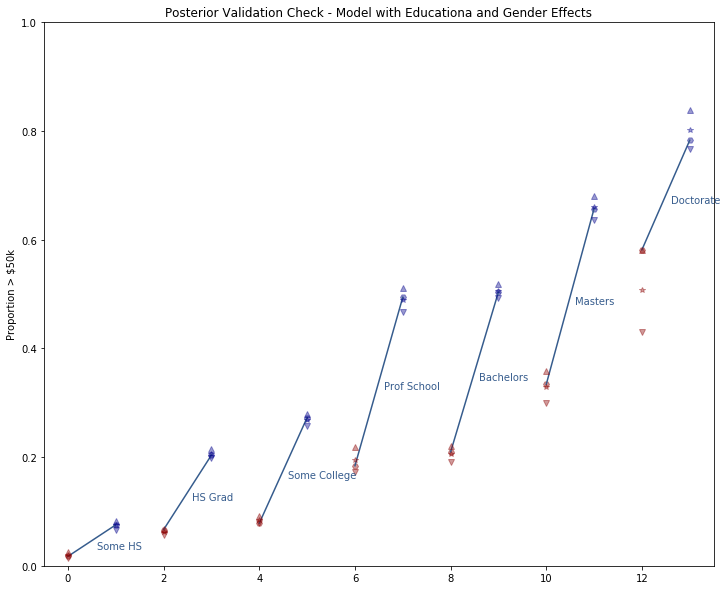

In [166]:
fig, ax = plt.subplots(figsize=(12, 10))

plot_post_validation_check(ax, y_obs, n, education_gender_ppc['y_obs'], labels, "Model with Educationa and Gender Effects")

**Analysis:**  We use the same posterior validation check visualization  we used earlier to understand our models that incorporate education categories.  Recall that the  data shows two trends:  males earning more than females within any given category and educational category having an impact on incompe potential with generally higher levels of education representing higher proportions earning >50K.  It's immediately clear that both models match the educational trend noted in the data, but the model incorporating education and gender effects  dies a good job of capturing both trends and makes good predictions for the income classification across gender and educational categories.